In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error as mse
from matplotlib import pyplot as plt

from tqdm import tqdm

## Codes from this file will not work since I removed/changed the data

In [2]:
krx = '/data/hun/KRX_marketdata/'

In [3]:
tickers = pd.read_csv(krx+'ticker_recent.csv', encoding ='cp949')
tickers.columns = ('full_ticker', 'ticker', 'name_full', 'name',
              'name_eng', 'listed_data', 'market', 'security_category',
              'related_department', 'preferred', 'face_value', 'shares')
tickers = tickers.drop(['related_department'], axis=1).dropna().reset_index(drop=True)

In [3]:
factors= pd.read_csv(krx+'factors.csv')
factors['ticker'] = factors.ticker.apply(lambda x: '0'*(6-len(str(x)))+str(x))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
interest1 = pd.read_excel(krx+'stat_107302.xls')
interest2 = pd.read_excel(krx+'stat_107301.xls')
interest = pd.concat([interest1.transpose(),interest2.transpose().drop(["Unnamed: 0"])]).reset_index()
int_col = ['date','tb3y','tb5y','tb10y','cb3y','cd3m','call','br']
interest.columns = int_col
interest.drop([0],axis=0, inplace=True)
interest["date"] = interest.date.apply(lambda x: f'{x[:4]}/{x[4:6]}')
interest.replace('-', np.nan, inplace=True)

interest['term_spread'] = interest['tb3y'].astype('float')- interest.br.astype('float')
interest['credit_spread'] = interest['cb3y'].astype('float') - interest.tb3y.astype('float')
interest = interest.dropna()

In [ ]:
factors = pd.merge(factors, interest[['date','cd3m','term_spread','credit_spread']], how='left', on='date')

In [ ]:
factors['trans_turn'] = prices.total_transactions/prices['size']
factors =factors.dropna()
factors.reset_index(drop = True, inplace = True)

In [6]:
factors.describe()

,ret,RM_RF,smb,hml,div_ret,PBR,EPR,BPR,size,share_turn,mom1,mom6,mom12,beta,beta_seq,ido_vol,cd3m,term_spread,credit_spread,trans_turn
count,367098.000000,367098.000000,367098.000000,367098.000000,367098.000000,367098.000000,367098.000000,367098.000000,367098.000000,367098.000000,367098.000000,367098.000000,367098.000000,367098.000000,367098.000000,367098.000000,367098.000000,367098.000000,367098.000000,367098.000000
mean,0.022826,0.002942,0.029222,0.004118,1.271247,1.644664,0.083455,1.040695,0.500123,0.387793,0.023124,0.023249,0.022955,0.463410,28.214998,0.821128,2.661427,0.531033,0.706400,0.412380
std,0.892897,0.091250,0.043141,0.052979,1.989090,5.732081,0.656990,1.306708,0.288705,3.868207,0.896392,0.363790,0.256622,5.291533,3523.952771,89.935896,1.371765,0.549941,0.521864,4.920248
min,-0.985862,-0.887071,-0.046105,-0.479083,0.000000,0.000000,0.000000,0.000000,0.000434,0.000004,-0.985862,-0.459365,-0.406501,-670.942221,0.000000,0.000000,0.630000,-0.340000,0.220000,0.000004
25%,-0.070175,-0.038905,0.002915,-0.014061,0.000000,0.480000,0.000000,0.333333,0.250000,0.029265,-0.070295,-0.024374,-0.014802,-0.046389,0.050577,0.006902,1.580000,0.140000,0.430000,0.029537
50%,-0.004076,0.007577,0.019467,0.008086,0.410000,0.940000,0.042863,0.781250,0.500000,0.086005,-0.003953,0.004187,0.006765,0.357565,0.310596,0.014389,2.630000,0.410000,0.530000,0.087124
75%,0.071103,0.051134,0.042318,0.030847,1.920000,1.770000,0.104058,1.428571,0.750136,0.242060,0.071339,0.041642,0.036077,0.941776,1.221496,0.031341,3.550000,0.740000,0.830000,0.247815
max,437.666667,0.184805,0.341170,0.167935,57.920000,1044.000000,100.000000,100.000000,1.000000,855.512794,437.666667,72.884900,36.465624,974.667766,949977.254124,16318.994101,6.030000,2.470000,4.380000,1777.534815


### Preprocessing


In [7]:
def xvar(data):
    return data.drop(['date','ticker','name'], axis=1).astype('float')

def xy(data):
    return data.drop(['ret'], axis=1), data.ret

In [9]:
dates = factors.date.unique()[::-1]

# Pooling

In [10]:
#preprocessing

length = len(dates)
ind_train = int(length*0.7)+2
ind_tv = int(length*0.4)
# pool_train_pre = factors[factors.date.apply(lambda x: x in dates[0:ind_train])]
# pool_test = factors[factors.date.apply(lambda x: x in dates[ind_train:])]

In [11]:
dates[ind_tv], dates[ind_train]

('2010/01', '2016/01')

In [12]:
## Time series split

pool_train = []
pool_val = []
pool_test = []
cnt = ind_tv
start= 0
for i in tqdm(range(12)):
    train_ind = dates[start:cnt-12]
    val_ind = dates[cnt-12:cnt]
    test_ind = dates[cnt:min(cnt+12, length)]
    
    pool_train.append(xvar(factors[factors.date.apply(lambda x: x in train_ind)]))
    pool_val.append(xvar(factors[factors.date.apply(lambda x: x in val_ind)]))
    pool_test.append(xvar(factors[factors.date.apply(lambda x: x in test_ind)]))
    cnt += 12
    start += 12

100%|██████████| 12/12 [01:15<00:00,  6.29s/it]


# Neural net

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

In [14]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.x_data=torch.FloatTensor(X.values)
        self.y_data=torch.FloatTensor(Y.values.reshape(-1,1))
    def __len__(self):     #len(dataset)으로 호출 가능
        return len(self.x_data)
    def __getitem__(self,idx):   #dataset[]으로 callable하게 된다
        x=self.x_data[idx]
        y=self.y_data[idx]
        return x, y

from sklearn.preprocessing import StandardScaler
def stdscaler(data_tensor):
    scalers = {}
    for i in range(data_tensor.shape[0]): #batch값을 넣어주기
        scalers[i] = StandardScaler()
        data_tensor[i, :, :] = torch.tensor(scalers[i].fit_transform(data_tensor[i, :, :]))
    return data_tensor


In [15]:
cuda = torch.cuda.is_available() # False
if cuda:
    device = 'cuda:2'
else:
    device = 'cpu'
cuda, device

(True, 'cuda:2')

### FC Models

In [16]:
class Net1(nn.Module):
    def __init__(self):
        self.name = 'Net1'
        super(Net1, self).__init__()
        self.fc1 = nn.Linear(19,16)
        self.fc2 = nn.Linear(16,1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class Net2(nn.Module):
    def __init__(self):
        self.name = 'Net2'
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(19,16)
        self.fc2 = nn.Linear(16,8)
        self.fc3 = nn.Linear(8,1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) 
        x = self.fc3(x)
        return x

class Net3(nn.Module):
    def __init__(self):
        self.name = 'Net3'
        super(Net3, self).__init__()
        self.fc1 = nn.Linear(19,16)
        self.fc2 = nn.Linear(16,8)
        self.fc3 = nn.Linear(8,4)
        self.fc4 = nn.Linear(4,1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) 
        x = F.relu(self.fc3(x)) 
        x = self.fc4(x)
        return x
    
class Net4(nn.Module):
    def __init__(self):
        self.name = 'Net4'
        super(Net4, self).__init__()
        self.fc1 = nn.Linear(19,16)
        self.fc2 = nn.Linear(16,8)
        self.fc3 = nn.Linear(8,4)
        self.fc4 = nn.Linear(4,2)
        self.fc5 = nn.Linear(2,1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) 
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

class Net5(nn.Module):
    def __init__(self):
        self.name = 'Net5'
        super(Net5, self).__init__()
        self.fc1 = nn.Linear(19,32)
        self.fc2 = nn.Linear(32,16)
        self.fc3 = nn.Linear(16,8)
        self.fc4 = nn.Linear(8,1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) 
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [17]:
def ros_nn(model, CustomData):
    model.eval()
    pred = model(CustomData.x_data.to(device)).cpu().detach().numpy().reshape(-1)
    real = CustomData.y_data.numpy().reshape(-1)
    ros = 1- ((pred - real)**2).mean()/(real**2).mean()
    return ros, pred

In [21]:
def torch_train(model, train_loader, valid_loader, period, ite = 700, lr = 0.01):
    criterion = torch.nn.MSELoss()
    optimizer = optim.Adagrad(model.parameters(), lr=lr, lr_decay=1e-9)
    
    loss_array_train = []
    loss_array_valid = []
    
    patience = 0
    min_loss = np.inf

    for i in tqdm(range(ite)):
        loss_array_train_tmp = []
        
        model.train()
        for batch_idx, samples in enumerate(train_loader):
            trainX_tensor, trainY_tensor=samples
            optimizer.zero_grad()
            out = model(trainX_tensor.to(device))
            loss = criterion(out, trainY_tensor.to(device))
            loss.backward()
            optimizer.step()
            loss_array_train_tmp.append(loss.item())
        loss_array_train.append(np.mean(loss_array_train_tmp))    

        torch.cuda.empty_cache() ## 캐시 비워주기 자주 해줘야함

        model.eval()
        loss_array_valid_tmp = []
        with torch.no_grad():
            for batch_idx, val_samples in enumerate(valid_loader):
                validX_tensor, validY_tensor=val_samples
                val_out = model(validX_tensor.to(device))
                val_loss = criterion(val_out, validY_tensor.to(device))
                loss_array_valid_tmp.append(val_loss.item())
            loss_array_valid.append(np.mean(loss_array_valid_tmp))

        ## update the minimum loss
        if min_loss > loss_array_valid[-1]:
            patience = 0
            min_loss = loss_array_valid[-1]
        else:
            patience += 1
        if patience > 20: ## early stop when patience become larger than 10
            break

        torch.cuda.empty_cache()
    
    path = f"./NN_save/{model.name}_{period}"
    torch.save(model.state_dict(), path+"_state")
    torch.save(model, path)
    
    train_loss, valid_loss = loss_array_train[-1], loss_array_valid[-1]
    print('Model: {}, period: {}, Train Loss: {:.4e}, Valid Loss: {:.4e}'.format(model.name, period, train_loss, valid_loss))
    print(patience)
    plt.plot(loss_array_train, label='Train Loss')
    plt.plot(loss_array_valid, label='Valid Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.yscale('log')
    plt.legend()
    plt.show()
    
    torch.cuda.empty_cache()
    return model, valid_loss, train_loss

# Training

In [19]:
nets = [Net1(), Net2(), Net3(), Net4(), Net5()]

## Testing

100%|██████████| 700/700 [27:21<00:00,  2.34s/it]


Model: Net1, period: 8, Train Loss: 8.1932e-02, Valid Loss: 2.1391e-02
0


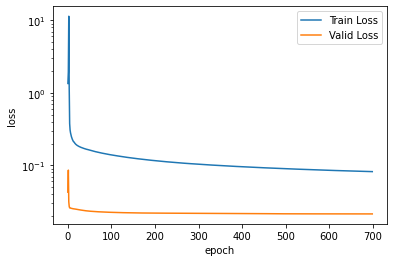


  0%|          | 0/700 [00:00<?, ?it/s]

-0.6322095394134521


  4%|▎         | 26/700 [01:26<37:22,  3.33s/it]


Model: Net2, period: 8, Train Loss: 6.2748e-02, Valid Loss: 1.9587e-02
21


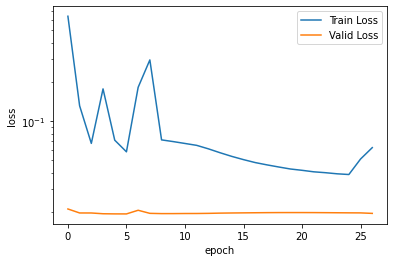


  0%|          | 0/700 [00:00<?, ?it/s]

0.41895633935928345


 18%|█▊        | 126/700 [08:32<38:54,  4.07s/it]


Model: Net3, period: 8, Train Loss: 3.9036e-02, Valid Loss: 1.4866e-02
21


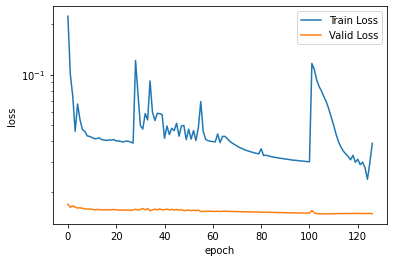


  0%|          | 0/700 [00:00<?, ?it/s]

0.3759394884109497


100%|██████████| 700/700 [43:21<00:00,  3.72s/it]


Model: Net4, period: 8, Train Loss: 4.0800e-02, Valid Loss: 2.6140e-02
0


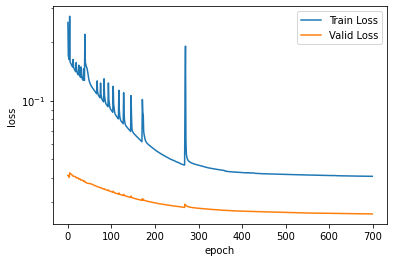


  0%|          | 0/700 [00:00<?, ?it/s]

0.3820614814758301


100%|██████████| 700/700 [41:45<00:00,  3.58s/it]


Model: Net5, period: 8, Train Loss: 2.0719e-02, Valid Loss: 1.4469e-02
0


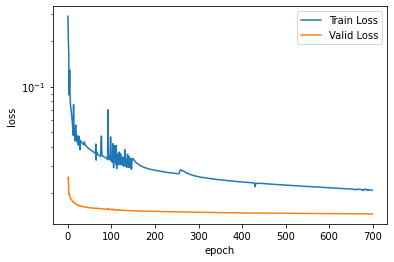

-1.107783555984497


  4%|▍         | 30/700 [01:15<27:58,  2.51s/it]


Model: Net1, period: 9, Train Loss: 1.1235e-01, Valid Loss: 6.9686e-02
21


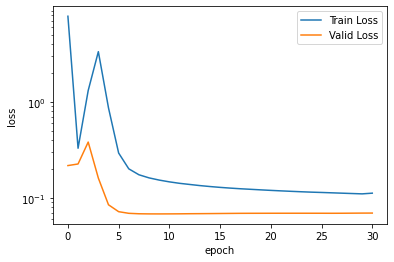


  0%|          | 0/700 [00:00<?, ?it/s]

-3989.837890625


  7%|▋         | 48/700 [02:35<35:10,  3.24s/it]


Model: Net2, period: 9, Train Loss: 3.4168e-02, Valid Loss: 2.4340e-02
21


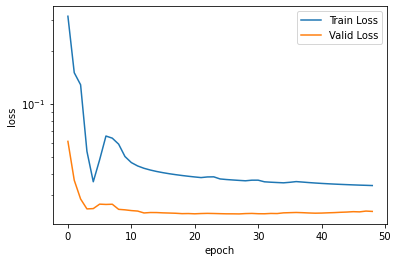


  0%|          | 0/700 [00:00<?, ?it/s]

-0.40608346462249756


  4%|▍         | 27/700 [01:57<48:56,  4.36s/it]


Model: Net3, period: 9, Train Loss: 4.0609e-02, Valid Loss: 2.3710e-02
21


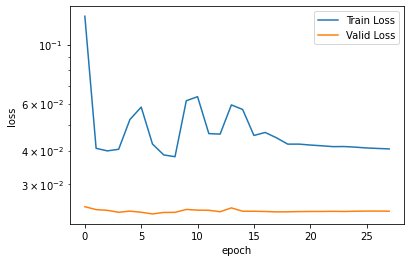


  0%|          | 0/700 [00:00<?, ?it/s]

0.3186364769935608


  3%|▎         | 23/700 [01:57<57:53,  5.13s/it]


Model: Net4, period: 9, Train Loss: 4.1412e-02, Valid Loss: 3.4483e-02
21


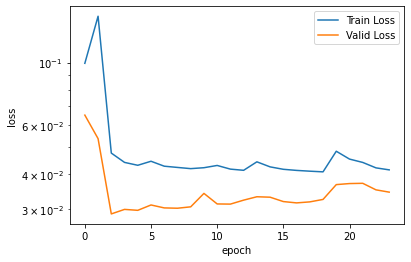


  0%|          | 0/700 [00:00<?, ?it/s]

-0.05568516254425049


  5%|▌         | 35/700 [02:29<47:15,  4.26s/it]


Model: Net5, period: 9, Train Loss: 3.1769e-02, Valid Loss: 8.4742e-02
21


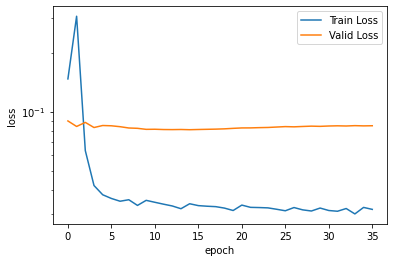

-38.99770736694336


  3%|▎         | 24/700 [01:05<30:47,  2.73s/it]


Model: Net1, period: 10, Train Loss: 6.8688e-02, Valid Loss: 1.9171e+02
21


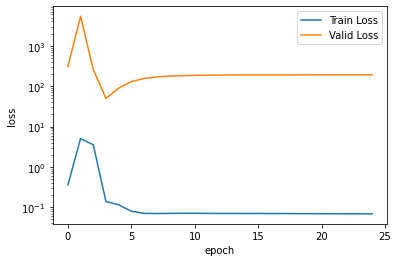


  0%|          | 0/700 [00:00<?, ?it/s]

-199.35459899902344


  6%|▌         | 41/700 [02:03<33:07,  3.02s/it]


Model: Net2, period: 10, Train Loss: 3.2412e-02, Valid Loss: 2.4030e-01
21


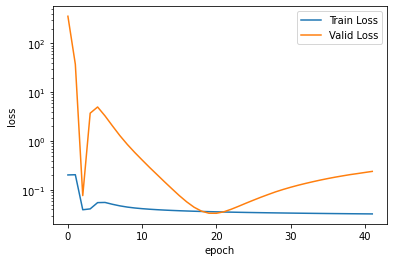


  0%|          | 0/700 [00:00<?, ?it/s]

0.2727484107017517


  3%|▎         | 22/700 [01:19<40:58,  3.63s/it]


Model: Net3, period: 10, Train Loss: 3.4755e-02, Valid Loss: 5.2033e-01
21


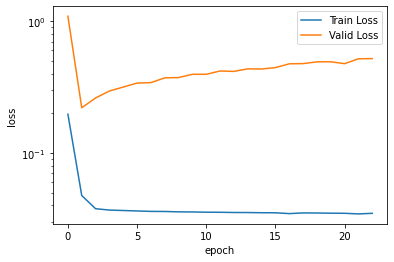


  0%|          | 0/700 [00:00<?, ?it/s]

0.13712400197982788


  5%|▍         | 32/700 [02:19<48:23,  4.35s/it]


Model: Net4, period: 10, Train Loss: 4.0127e-02, Valid Loss: 5.5249e-02
21


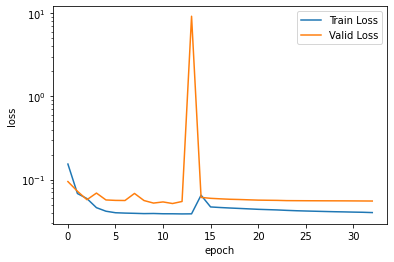


  0%|          | 0/700 [00:00<?, ?it/s]

0.26458412408828735


  3%|▎         | 22/700 [01:26<44:31,  3.94s/it]


Model: Net5, period: 10, Train Loss: 2.9480e-02, Valid Loss: 3.0099e+00
21


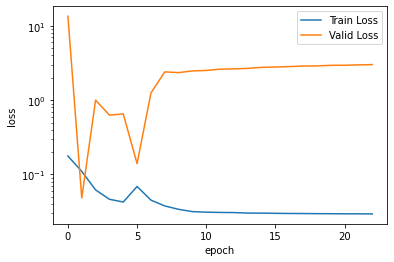

-2.233685255050659


100%|██████████| 700/700 [30:23<00:00,  2.61s/it]


Model: Net1, period: 11, Train Loss: 3.2676e-02, Valid Loss: 1.1492e-01
0


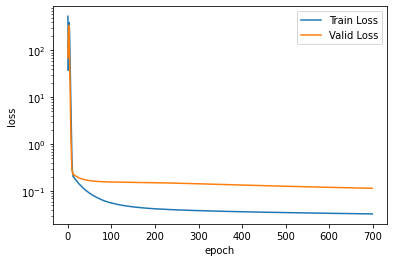


  0%|          | 0/700 [00:00<?, ?it/s]

-1.625199794769287


  5%|▌         | 35/700 [02:06<40:01,  3.61s/it]


Model: Net2, period: 11, Train Loss: 2.0645e-02, Valid Loss: 8.3093e-02
21


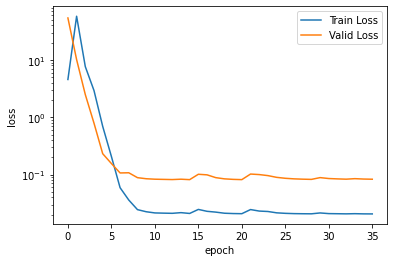


  0%|          | 0/700 [00:00<?, ?it/s]

0.0074928998947143555


  5%|▌         | 37/700 [02:53<51:51,  4.69s/it]


Model: Net3, period: 11, Train Loss: 7.6215e-02, Valid Loss: 1.6730e-01
21


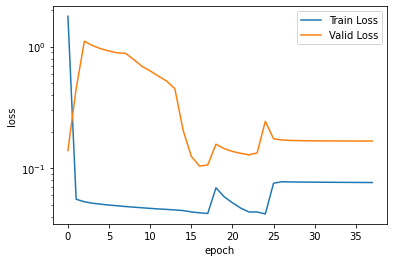


  0%|          | 0/700 [00:00<?, ?it/s]

-0.1196897029876709


  3%|▎         | 23/700 [02:11<1:04:18,  5.70s/it]


Model: Net4, period: 11, Train Loss: 8.1493e-02, Valid Loss: 1.8465e-01
21


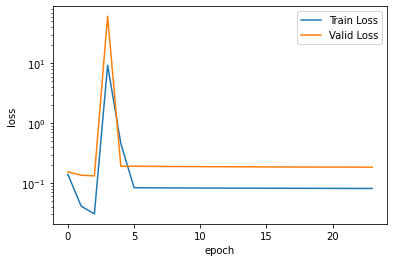


  0%|          | 0/700 [00:00<?, ?it/s]

-0.2899622917175293


  4%|▍         | 28/700 [02:11<52:45,  4.71s/it]


Model: Net5, period: 11, Train Loss: 1.8196e-02, Valid Loss: 9.4743e-02
21


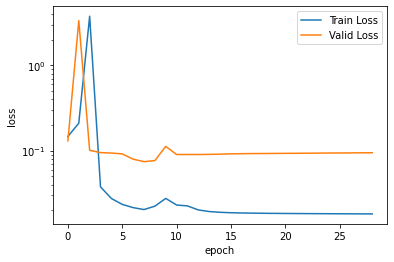

-0.21185874938964844


In [22]:
results = pd.DataFrame(columns = ['model','period','r_squared','valid_loss','train_loss'])
results.to_csv('NN_test_res_rolling0_11.csv', index = False)
model_name = [i.name for i in nets]
preds = pd.DataFrame(columns = model_name)
preds.to_csv('NN_test_pred0_11.csv', index = False)

for period in range(8,12):
    train_set, val_set, test_set = pool_train[period], pool_val[period], pool_test[period]
    train_x, train_y = xy(train_set)
    val_x, val_y = xy(val_set)
    test_x, test_y = xy(test_set)
    
    train_data, valid_data = CustomDataset(train_x,train_y), CustomDataset(val_x, val_y)
    test_data = CustomDataset(test_x, test_y)
    
    train_loader = DataLoader(train_data, batch_size=120, shuffle=False, pin_memory=True)
    valid_loader = DataLoader(valid_data, batch_size=120, shuffle=False, pin_memory=True)
    
    r_squared, valid_loss, train_loss =[], [], []
    predicted = []
    for model in nets:
        model = model.to(device)
        model_trained, val_loss, tr_loss = torch_train(model, train_loader, valid_loader, period)
        valid_loss.append(val_loss)
        train_loss.append(tr_loss)
        
        r_sq, pred_res = ros_nn(model, test_data)
        r_squared.append(r_sq)
        predicted.append(pred_res)
        print(r_sq)

    res_temp = pd.DataFrame({"model": model_name, "period": [period]*5, "r_squared": r_squared, 
                             "valid_loss": valid_loss, "train_loss": train_loss})
    
    pred_temp = pd.DataFrame({"Net1":predicted[0], "Net2":predicted[1], "Net3":predicted[2], 
                              "Net4":predicted[3], "Net5":predicted[4]})
    
    res_temp.to_csv('NN_test_res_rolling0_11.csv', index = False, header = False, mode ='a')
    pred_temp.to_csv('NN_test_pred0_11.csv', index = False, header = False, mode ='a')
